In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSimHebb
from SpikingNetworkModels import EIFNetworkSim

#from DefaultParams import *




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np

# Time duration and step size of sim in ms
T=12000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)
Tburn=2000
Nburn=int(Tburn/dt)

# Number of E and I neurons in network
Ne = 4000
Ni = 1000
Ns=[Ne,Ni]
N = Ne+Ni


# Connection probabilities and weights between
# E and I neurons
P = np.array([[.1,.1],[.1,.1]])
Jm = 0.5*np.array([[25.0,-150.0],[112.5,-250.0]])/np.sqrt(N)

# Synaptic time constants in ms
tau=np.array([8.0,4.0])


# Neuron parameters
NeuronParams = dict()
NeuronParams['Cm']=1.0
NeuronParams['gL']=1/15.0
NeuronParams['EL']=-72.0
NeuronParams['Vth']=0.0
NeuronParams['Vre']=-75.0
NeuronParams['Vlb']=-100.0
NeuronParams['DeltaT']=1.0
NeuronParams['VT']=-55.0


# Mean-field variables
Q=np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)
Xmf = 0.6*np.array([.04,.02])

# Baseline external input to each neuron
X0 = Xmf*np.sqrt(N)

# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf

# Stimulus params
StimDim = 10
taustim = 25.0
sigmastim = X0.mean()/3.0

print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Params for multi-trial sims
numtrials=2
dtRate=250


tauHebb=20.0
etaHebb=Jm[0,0]/50.0

rBal =  9.882352941176466 22.588235294117638 Hz


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[]

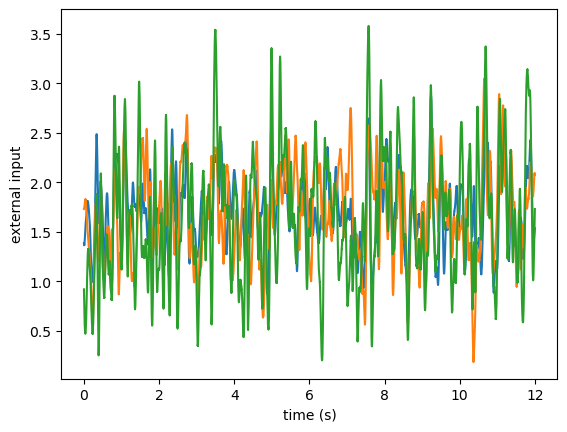

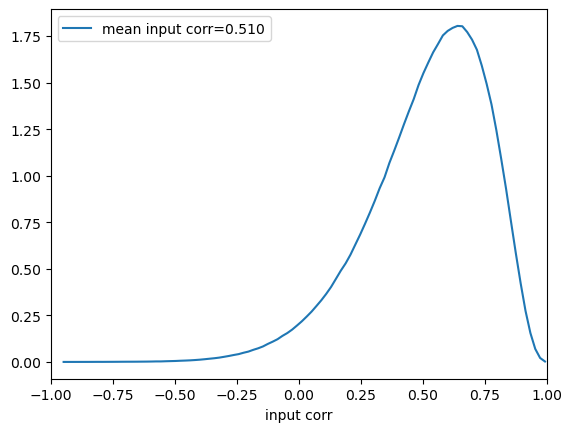

In [3]:
# This code cell creates connectivity and stimulus
    
# Get connectivity matrix
J0=GetBlockErdosRenyi(Ns,Jm,P,Ns)
J=J0.copy()

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)

#Jx=np.zeros(N,StimDim)
Jx=sigmastim*(0.4*np.random.randn(N,StimDim)+.4)
Jx[Ne:,:]=0

cellnums=[0,10,20]
plt.figure()
plt.plot(time/1000,(Jx[cellnums,:]@X).T+X0[0])
plt.xlabel('time (s)')
plt.ylabel('external input')

# Compute input correlations
Xcoarse = X.reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
IEXcoarse=Jx[:Ne,:]@Xcoarse
IEXcoarse = IEXcoarse[:,3:-3]
XXCorr = np.corrcoef(IEXcoarse)
XXCorr=XXCorr[np.triu_indices_from(XXCorr,k=1)]

hAllXX,bAllXX=np.histogram(XXCorr,100,density=True,)
plt.figure()
plt.plot(bAllXX[1:],hAllXX,label="mean input corr={:.3f}".format(XXCorr.mean()))
plt.xlim([-1,1])
plt.legend()
plt.xlabel('input corr')
[]

In [4]:
#This code cell runs sims

import warnings

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
reRand = np.zeros((numtrials,Ne,len(RateTime)))
riRand = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for iii in range(numtrials): 
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reRand[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        riRand[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print('Sim for trial',iii+1,'of',numtrials,'complete after',tm()-t0,'s.',' Rates =',1000*reRand[iii,:,:].mean(),1000*riRand[iii,:,:].mean())        
tSim=tm()-t0
print('Time for all sims:',tSim,'s')


MeanERates=reRand.mean()
MeanIRates=riRand.mean()

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


Ve0  -63.75222156956439
Sim for trial 1 of 2 complete after 26.881942987442017 s.  Rates = 8.698958333333335 16.06525
Ve0  -74.8081083381088
Sim for trial 2 of 2 complete after 53.620038747787476 s.  Rates = 8.701583333333334 16.0665
Time for all sims: 53.62032413482666 s
rSim = 8.700270833333335 16.065875 Hz


3743 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2
Mean EE corr: 0.043373039616708506
Std EE corr: 0.2617071755149366
Mean connected EE corr: 0.04726550205216871
Mean unconnected EE corr: 0.04294072857421886
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[]

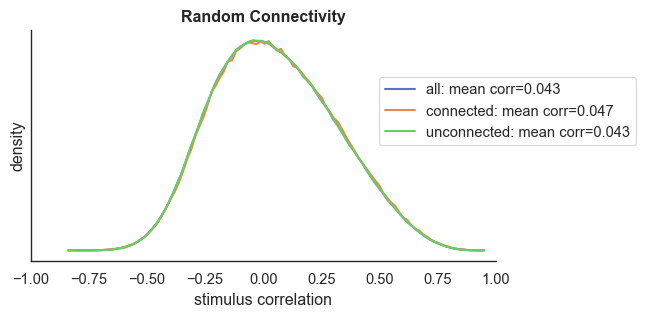

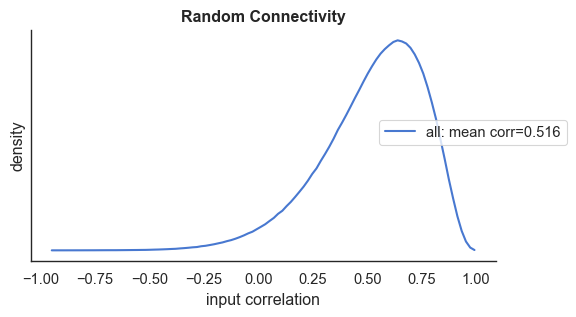

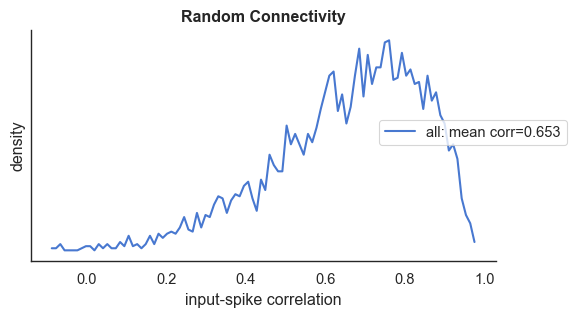

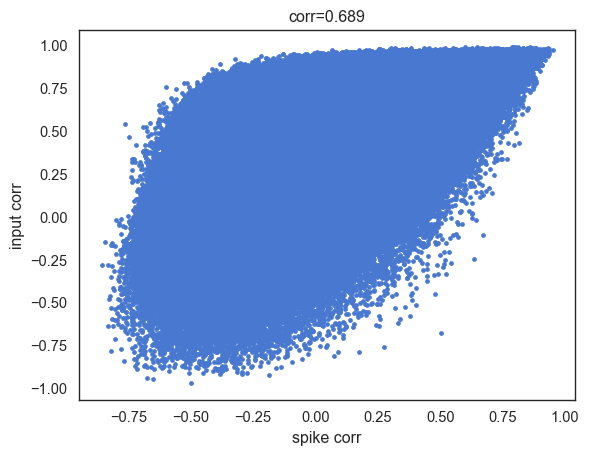

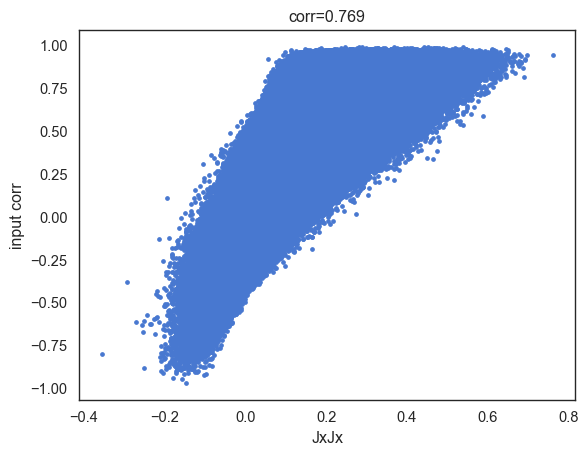

In [5]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

nt=numtrials


# Counts from rates with burn-in and losing last bins bc of noise stuff
ECounts = dtRate*reRand[:nt,:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]


# Average over trials
#ECounts = ECounts.mean(axis=0)
ECounts=ECounts[0,:,:]


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
#CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
Xcoarse = X.reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
IEXcoarse = Jx[:Ne,:]@Xcoarse
IEXcoarse = IEXcoarse[:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]
CutoffEXCorrMatrix = np.corrcoef(ECounts[ECutoffInds],IEXcoarse[ECutoffInds])

CutoffEECorrMatrix = CutoffEXCorrMatrix[:,:numGood][:numGood,:]
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

CutoffXXCorrMatrix = CutoffEXCorrMatrix[:,numGood:][numGood:,:]
AllXXCorrs = CutoffXXCorrMatrix[np.triu_indices_from(CutoffXXCorrMatrix,k=1)]

CutoffEXCorrMatrix = CutoffEXCorrMatrix[:,:numGood][numGood:,:]
# AllEXCorrs = CutoffEXCorrMatrix[np.triu_indices_from(CutoffEXCorrMatrix,k=0)]
AllEXCorrs = np.diag(CutoffEXCorrMatrix)

JxJxCutoff=(Jx[ECutoffInds,:]@Jx[ECutoffInds,:].T)
AllJxJx = JxJxCutoff[np.triu_indices_from(JxJxCutoff,k=1)]



Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())




hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

hAllXX,bAllXX=np.histogram(AllXXCorrs,100,density=True)
hAllEX,bAllEX=np.histogram(AllEXCorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

# Save figure if needed
SaveFigures=False
if SaveFigures:
    plt.savefig('./Figures/MultiTrialRandomConn.png')


plt.figure(figsize=(6,3))
plt.plot(bAllXX[1:],hAllXX, label="all: mean corr={:.3f}".format(AllXXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

plt.figure(figsize=(6,3))
plt.plot(bAllEX[1:],hAllEX, label="all: mean corr={:.3f}".format(AllEXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input-spike correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

CorrEEXX = np.corrcoef(AllEECorrs,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllEECorrs,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrEEXX))
plt.xlabel('spike corr')
plt.ylabel('input corr')


CorrJexXX = np.corrcoef(AllJxJx,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllJxJx,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrJexXX))
plt.xlabel('JxJx')
plt.ylabel('input corr')

[]

rSim = 8.700270833333335 16.065875 Hz


[]

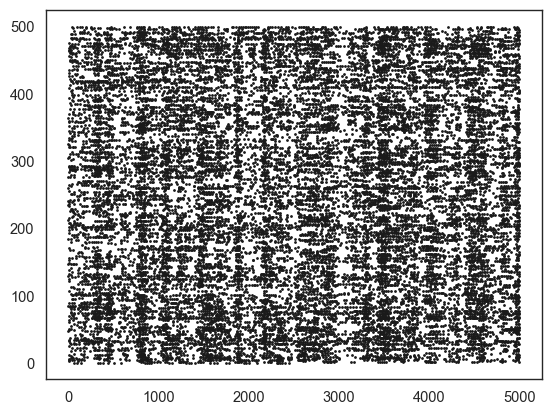

In [6]:

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


plt.figure()
NePlot=500
TPlot=5000
msize=2
Inds=np.where(np.logical_and(se[1,:]<NePlot , se[0,:]<=TPlot))
plt.plot(se[0,Inds],se[1,Inds]+1,'k.',markersize=msize)

# plt.figure()
# whichV=0
# Vplot=VeRec[time<=TPlot,whichV]
# PlotSpikeTimeInds = (se[0,se[1,:]==Ierecord[whichV]]/dt).astype(int)
# Vplot[PlotSpikeTimeInds]=0
# Vplot[Vplot>=0]=0

# plt.plot(time[time<=TPlot],Vplot)

[]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.5098931156933334 (4000, 4000) 0.10000000000000003
[[0.         0.0848571  0.10779858 0.08954746 0.08285634]
 [0.0848571  0.         0.10865953 0.09975844 0.10761655]
 [0.10779858 0.10865953 0.         0.07283657 0.07924449]
 [0.08954746 0.09975844 0.07283657 0.         0.12568762]
 [0.08285634 0.10761655 0.07924449 0.12568762 0.        ]]
0.01766500789886307 0.017677669529663688


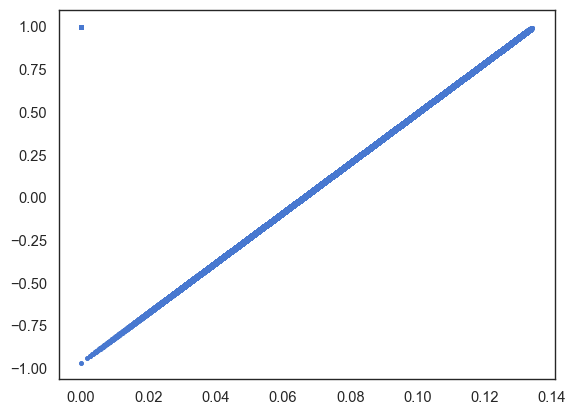

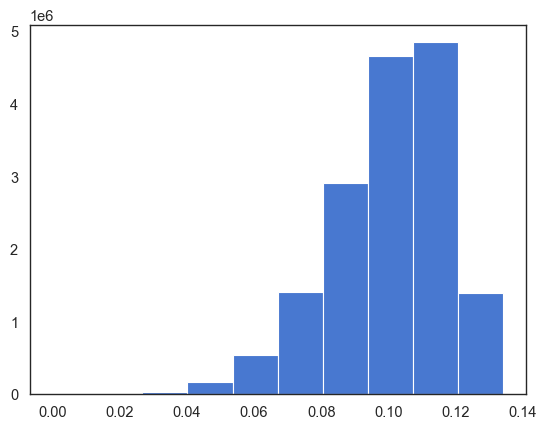

In [10]:
#This code cell runs sims

# import warnings
# t0=tm()
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=RuntimeWarning)
#     J=J0.copy()
#     _,_,_ = EIFNetworkSimHebb(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord,etaHebb,tauHebb)
#     se=se[:,se[0,:]>=0]
#     si=si[:,si[0,:]>=0]
#     reHebb = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
#     riHebb = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
#     print('Sim for Hebb','complete after',tm()-t0,'s.',' Rates =',1000*reHebb.mean(),1000*riHebb.mean())        


# Compute input correlations
Xcoarse = X.reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
Jx[:Ne,:]@Xcoarse
IEXcoarse = IEXcoarse[:,4:-4]
XXCorrMatrix = np.corrcoef(IEXcoarse)


p0=0.1
alpha=1.0

Pe1=XXCorrMatrix.copy()
Pe1=Pe1-Pe1.min()
Pe1=Pe1-Pe1*np.eye(Ne)
Pe1 = Pe1*(alpha*p0/Pe1.mean())
Pe1[Pe1<0]=0
print(XXCorr.mean(),XXCorrMatrix.shape,Pe1.mean())
print(Pe1[:5,:5])

plt.figure()
plt.plot(Pe1.flatten(),XXCorrMatrix.flatten(),'.')

plt.figure()
plt.hist(Pe1.flatten())
[]

MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))

J=J0.copy()
J[:Ne,:Ne]=MaskEE*J[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))

print(J[:Ne,:Ne].mean(),Jm[0,0]*p0)




In [11]:
#This code cell runs sims

import warnings

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
reLikeLike = np.zeros((numtrials,Ne,len(RateTime)))
riLikeLike = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for iii in range(numtrials): 
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reLikeLike[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        riLikeLike[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print('Sim for trial',iii+1,'of',numtrials,'complete after',tm()-t0,'s.',' Rates =',1000*reLikeLike[iii,:,:].mean(),1000*riLikeLike[iii,:,:].mean())        
tSim=tm()-t0
print('Time for all sims:',tSim,'s')


MeanERatesLikeLike=reLikeLike.mean()
MeanIRatesLikeLike=riLikeLike.mean()

print('rSim =',1000*MeanERatesLikeLike,1000*MeanIRatesLikeLike,'Hz')


Ve0  -71.51742674169328
Sim for trial 1 of 2 complete after 27.080488920211792 s.  Rates = 8.870854166666668 16.33625
Ve0  -60.66774417497401
Sim for trial 2 of 2 complete after 54.211493730545044 s.  Rates = 8.870895833333332 16.336333333333336
Time for all sims: 54.21186685562134 s
rSim = 8.870875000000002 16.336291666666668 Hz


3816 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2
Mean EE corr: 0.041119471561016314
Std EE corr: 0.26592189692702956
Mean connected EE corr: 0.0766805575794737
Mean unconnected EE corr: 0.03717638650288077
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[]

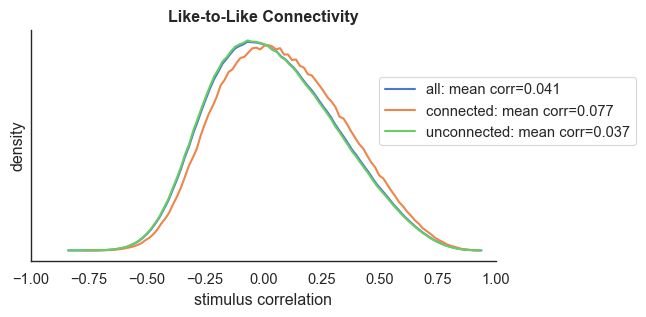

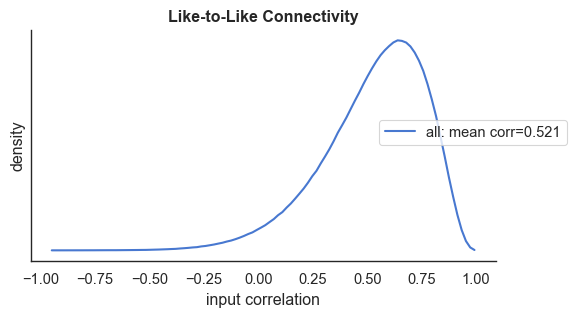

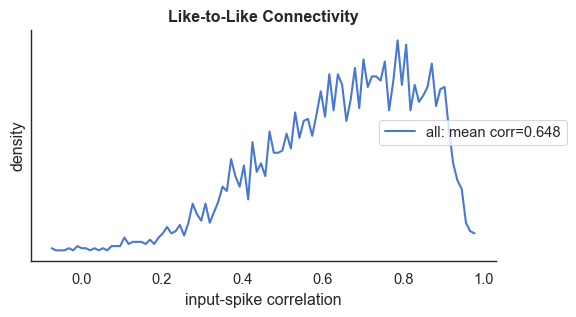

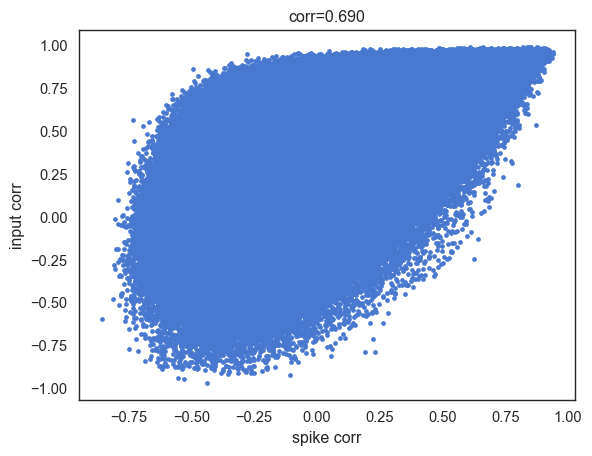

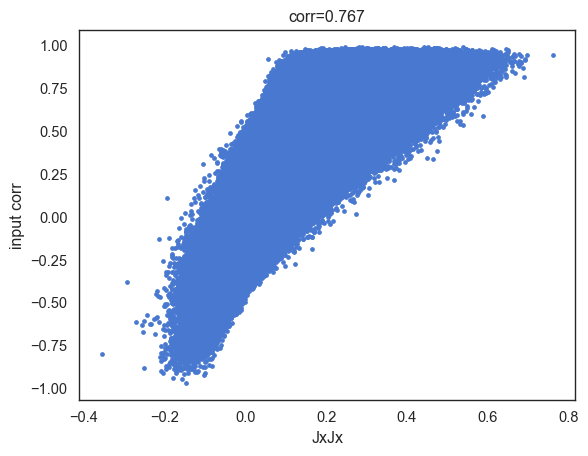

In [16]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

nt=numtrials


# Counts from rates with burn-in and losing last bins bc of noise stuff
ECounts = dtRate*reLikeLike[:nt,:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]


# Average over trials
#ECounts = ECounts.mean(axis=0)
ECounts=ECounts[0,:,:]


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
#CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
Xcoarse = X.reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
IEXcoarse = Jx[:Ne,:]@Xcoarse
IEXcoarse = IEXcoarse[:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]
CutoffEXCorrMatrix = np.corrcoef(ECounts[ECutoffInds],IEXcoarse[ECutoffInds])

CutoffEECorrMatrix = CutoffEXCorrMatrix[:,:numGood][:numGood,:]
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

CutoffXXCorrMatrix = CutoffEXCorrMatrix[:,numGood:][numGood:,:]
AllXXCorrs = CutoffXXCorrMatrix[np.triu_indices_from(CutoffXXCorrMatrix,k=1)]

CutoffEXCorrMatrix = CutoffEXCorrMatrix[:,:numGood][numGood:,:]
# AllEXCorrs = CutoffEXCorrMatrix[np.triu_indices_from(CutoffEXCorrMatrix,k=0)]
AllEXCorrs = np.diag(CutoffEXCorrMatrix)

JxJxCutoff=(Jx[ECutoffInds,:]@Jx[ECutoffInds,:].T)
AllJxJx = JxJxCutoff[np.triu_indices_from(JxJxCutoff,k=1)]



Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())




hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

hAllXX,bAllXX=np.histogram(AllXXCorrs,100,density=True)
hAllEX,bAllEX=np.histogram(AllEXCorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()

# Save figure if needed
SaveFigures=False
if SaveFigures:
    plt.savefig('./Figures/MultiTrialLikeLikeConn.png')


plt.figure(figsize=(6,3))
plt.plot(bAllXX[1:],hAllXX, label="all: mean corr={:.3f}".format(AllXXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()

plt.figure(figsize=(6,3))
plt.plot(bAllEX[1:],hAllEX, label="all: mean corr={:.3f}".format(AllEXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input-spike correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()

CorrEEXX = np.corrcoef(AllEECorrs,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllEECorrs,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrEEXX))
plt.xlabel('spike corr')
plt.ylabel('input corr')


CorrJexXX = np.corrcoef(AllJxJx,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllJxJx,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrJexXX))
plt.xlabel('JxJx')
plt.ylabel('input corr')

[]